In [ ]:
# Cell A: install dependencies (run once)
!pip install --quiet pandas numpy yfinance networkx matplotlib seaborn scipy python-louvain


In [ ]:
# Cell C: Upload ind_nifty500list.csv via Colab UI (if not using Drive)
from google.colab import files
uploaded = files.upload()  # a file picker will open
# After uploading, note the filename printed below
for fn in uploaded.keys():
    print("Uploaded:", fn)


Saving ind_nifty500list.csv to ind_nifty500list.csv
Uploaded: ind_nifty500list.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# === Colab path configuration ===
IND_LIST_CSV = "/content/ind_nifty500list.csv"   # your uploaded file
OUTPUT_DIR = "/content/drive/MyDrive/stock_network_output"  # <- save results here
PRICES_CSV = OUTPUT_DIR + "/prices_cache.csv"

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Input file:", IND_LIST_CSV)
print("Output directory:", OUTPUT_DIR)
print("Price cache:", PRICES_CSV)


Input file: /content/ind_nifty500list.csv
Output directory: /content/drive/MyDrive/stock_network_output
Price cache: /content/drive/MyDrive/stock_network_output/prices_cache.csv


Reading ticker list from: /content/ind_nifty500list.csv
Found 200 tickers in list (using top 200)
Prepared 200 Yahoo tickers (first 10): ['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'ACMESOLAR.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AWL.NS', 'AADHARHFC.NS']
  fetching batch 1 (80 tickers)...
  fetching batch 2 (80 tickers)...


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: DUMMYDBRLT.NS"}}}
ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: DUMMYSKFIN.NS"}}}
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['DUMMYDBRLT.NS', 'DUMMYSKFIN.NS', 'DUMMYTATAM.NS']: YFTzMissingError('possibly delisted; no timezone found')


  fetching batch 3 (40 tickers)...
Saved cached prices to /content/drive/MyDrive/stock_network_output/prices_cache.csv
Prices shape: (701, 120)
Saved log_returns.csv (shape (700, 108)).
Saved correlation_matrix.csv
Threshold graph: nodes=108, edges=14
MST graph: nodes=108, edges=107
Saved network_measures_threshold.csv


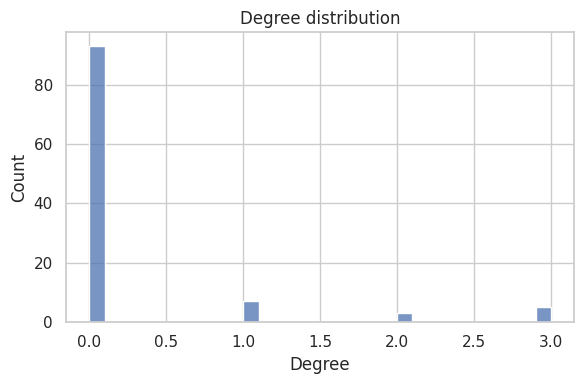

Threshold graph degree assortativity: 0.5942028985507245


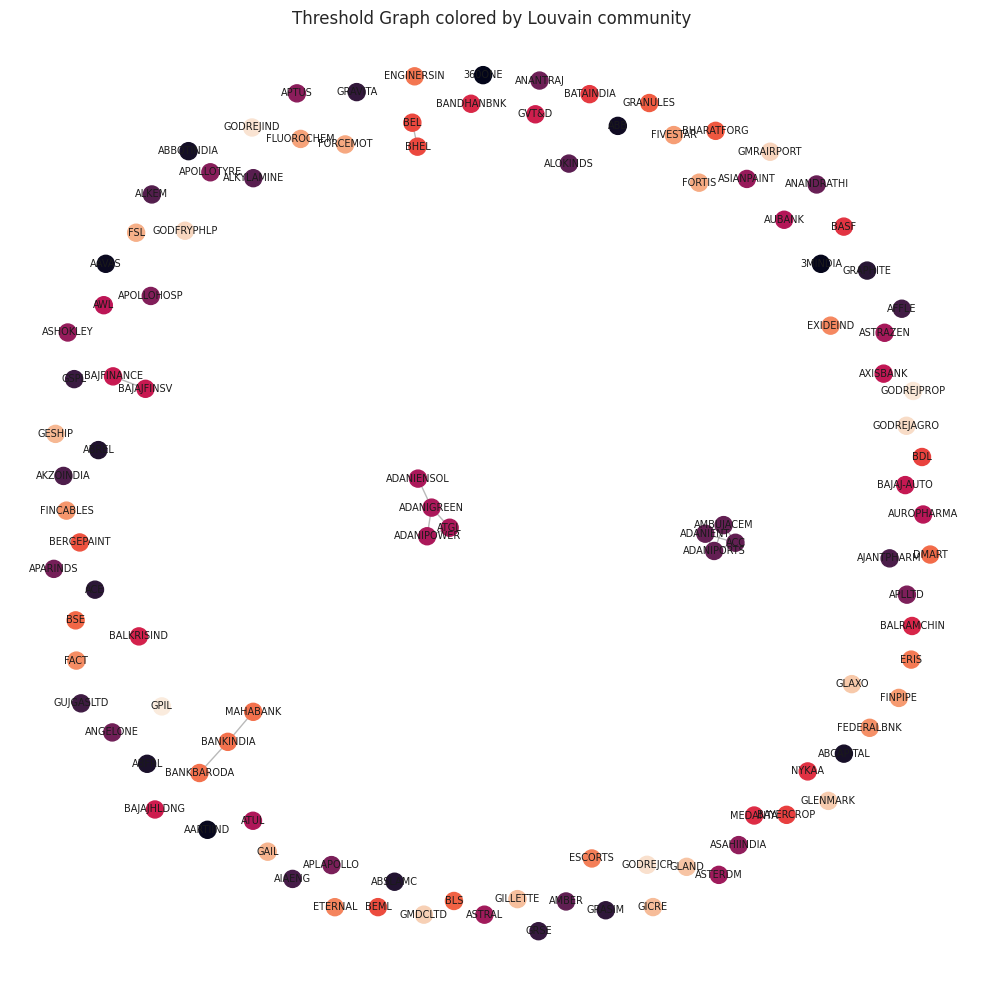

Saved communities_threshold.csv and network_threshold_communities.png


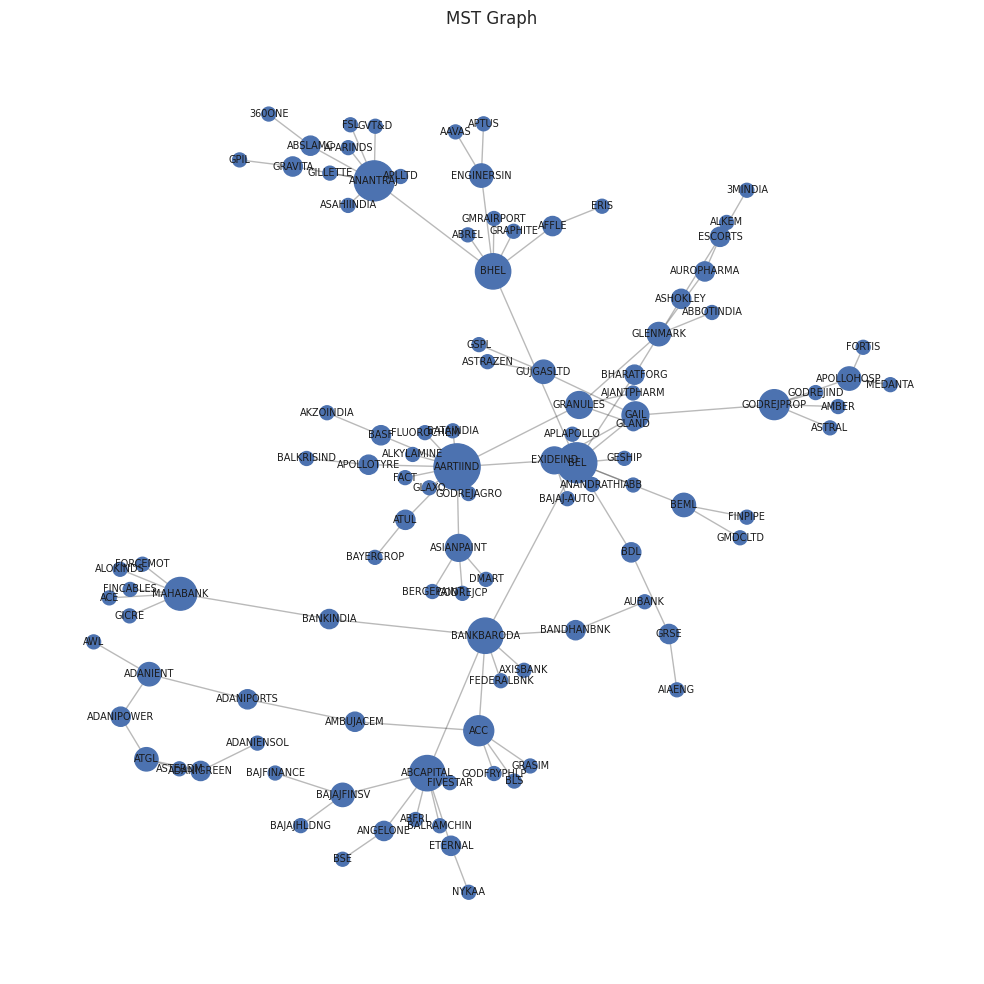

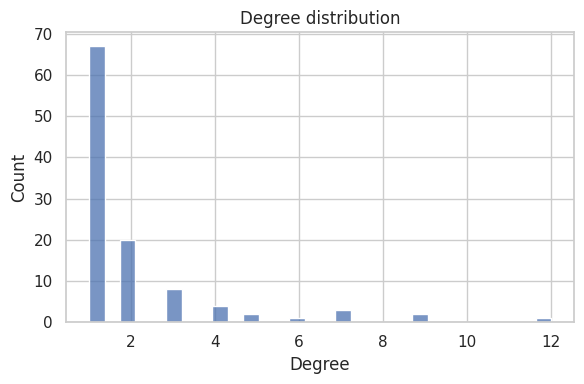

Saved MST measures and plots. MST assortativity: -0.3038794372166952
Pipeline complete. All outputs are in: /content/drive/MyDrive/stock_network_output
List output folder contents (top 30):
total 5.0M
-rw------- 1 root root  109 Nov  5 04:08 assortativity.txt
-rw------- 1 root root 1.2K Nov  5 04:08 communities_threshold.csv
-rw------- 1 root root 224K Nov  5 04:08 correlation_matrix.csv
-rw------- 1 root root  16K Nov  5 04:08 degree_dist_mst.png
-rw------- 1 root root  14K Nov  5 04:08 degree_dist_threshold.png
-rw------- 1 root root  15K Nov  5 04:08 graph_mst.gexf
-rw------- 1 root root 8.0K Nov  5 04:08 graph_threshold_60.gexf
-rw------- 1 root root 1.6M Nov  5 04:08 log_returns.csv
-rw------- 1 root root 9.1K Nov  5 04:08 network_measures_mst.csv
-rw------- 1 root root 3.8K Nov  5 04:08 network_measures_threshold.csv
-rw------- 1 root root 286K Nov  5 04:08 network_mst.png
-rw------- 1 root root 229K Nov  5 04:08 network_threshold_communities.png
-rw------- 1 root root 1.3M Nov  

In [ ]:
# Cell 3 — Full pipeline: read tickers, (cached) download prices, compute returns, build networks, save outputs
import os
import time
import warnings
from typing import Optional, List

import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform
from community import community_louvain  # python-louvain

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# -------------------- CONFIG --------------------
TICKER_COL = "Symbol"      # column name in ind_nifty500list.csv containing tickers
TICKER_SUFFIX = ".NS"      # append to ticker if missing for Yahoo Finance
START_DATE = "2023-01-01"  # adjust as needed
END_DATE = None            # None -> up to today's date
MIN_STOCKS = 100
N_STOCKS = 200             # top N tickers to use from the list (edit if you want 100/500)
DOWNLOAD_SLEEP = 0.05      # pause between yfinance batches
CORR_METHOD = "pearson"
THRESHOLD = 0.6            # correlation threshold for threshold graph
USE_ABS_CORR = True        # use absolute correlation when thresholding
BUILD_MST = True           # build MST in addition to threshold graph
OUTPUT_DIR = os.path.abspath("{}".format("/content/drive/MyDrive/stock_network_output"))
PRICES_CSV = os.path.join(OUTPUT_DIR, "prices_cache.csv")
# -----------------------------------------------

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- helper functions ----------
def read_ticker_list(csv_path: str, ticker_col: str = "Symbol", n: Optional[int] = None) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # try alternative common column names if TICKER_COL absent
    if ticker_col not in df.columns:
        for alt in ['SYMBOL','symbol','Ticker','TICKER','CODE']:
            if alt in df.columns:
                df = df.rename(columns={alt: ticker_col})
                break
    if ticker_col not in df.columns:
        raise ValueError(f"Ticker column '{ticker_col}' not found in {csv_path}. Columns: {df.columns.tolist()}")
    df = df.dropna(subset=[ticker_col]).drop_duplicates(subset=[ticker_col])
    if n:
        df = df.iloc[:n].copy()
    df[ticker_col] = df[ticker_col].astype(str).str.upper().str.strip()
    return df

def prepare_yf_tickers(symbols: List[str], suffix: str = ".NS") -> List[str]:
    yf_tickers = []
    for s in symbols:
        s = s.strip()
        yf_tickers.append(s if s.endswith(suffix) else s + suffix)
    return yf_tickers

def download_prices(tickers: List[str], start: str, end: Optional[str] = None, cache_path: Optional[str] = None) -> pd.DataFrame:
    # Use cached file if present
    if cache_path and os.path.exists(cache_path):
        print(f"Loading cached prices from {cache_path} ...")
        df = pd.read_csv(cache_path, index_col=0, parse_dates=True)
        return df

    print("Downloading price data from yfinance (this may take several minutes)...")
    batch_size = 80
    price_dfs = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"  fetching batch {i // batch_size + 1} ({len(batch)} tickers)...")
        data = yf.download(batch, start=start, end=end, progress=False, threads=True)
        if 'Adj Close' in data:
            adj = data['Adj Close'].copy()
        elif 'Close' in data:
            adj = data['Close'].copy()
        else:
            raise RuntimeError("yfinance returned unexpected data format.")
        adj = adj.dropna(axis=1, how='all')
        price_dfs.append(adj)
        time.sleep(DOWNLOAD_SLEEP)

    if not price_dfs:
        raise RuntimeError("No price data downloaded.")
    prices = pd.concat(price_dfs, axis=1)
    # Normalize column names: remove suffix like ".NS"
    prices.columns = [str(c).split('.')[0] for c in prices.columns]
    prices = prices.sort_index()
    if cache_path:
        prices.to_csv(cache_path)
        print(f"Saved cached prices to {cache_path}")
    return prices

def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    na_frac = prices.isna().mean()
    keep = na_frac[na_frac < 0.25].index.tolist()  # keep tickers with <25% missing
    prices = prices[keep].copy()
    prices = prices.fillna(method='ffill').fillna(method='bfill')
    returns = np.log(prices / prices.shift(1)).dropna(how='all')
    return returns

def correlation_matrix(returns: pd.DataFrame, method: str = "pearson") -> pd.DataFrame:
    return returns.corr(method=method)

def corr_to_distance_matrix(corr: pd.DataFrame) -> pd.DataFrame:
    D = np.sqrt(np.clip(2 * (1 - corr.values), 0, None))  # Mantegna distance
    return pd.DataFrame(D, index=corr.index, columns=corr.columns)

def build_threshold_graph(corr: pd.DataFrame, threshold: float, use_abs: bool = True) -> nx.Graph:
    G = nx.Graph()
    cols = corr.columns.tolist()
    G.add_nodes_from(cols)
    for i, u in enumerate(cols):
        for j in range(i + 1, len(cols)):
            v = cols[j]
            val = corr.iat[i, j]
            test_val = abs(val) if use_abs else val
            if pd.notna(test_val) and test_val >= threshold:
                G.add_edge(u, v, weight=float(val), abs_weight=float(abs(val)))
    return G

def build_mst_graph(dist_df: pd.DataFrame) -> nx.Graph:
    G_full = nx.Graph()
    cols = dist_df.columns.tolist()
    for i, u in enumerate(cols):
        for j in range(i + 1, len(cols)):
            v = cols[j]
            G_full.add_edge(u, v, weight=float(dist_df.iat[i, j]))
    mst = nx.minimum_spanning_tree(G_full, weight='weight')
    return mst

def compute_network_measures(G: nx.Graph) -> pd.DataFrame:
    nodes = list(G.nodes())
    deg = dict(G.degree())
    deg_c = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, normalized=True)
    clos = {n: nx.closeness_centrality(G, n) for n in nodes}
    try:
        eig = nx.eigenvector_centrality_numpy(G)
    except Exception:
        eig = {n: np.nan for n in nodes}
    clustering = nx.clustering(G)
    try:
        partition = community_louvain.best_partition(G, weight='weight')
    except Exception:
        partition = {n: -1 for n in nodes}
    df = pd.DataFrame({
        "node": nodes,
        "degree": [deg.get(n, 0) for n in nodes],
        "deg_centrality": [deg_c.get(n, 0) for n in nodes],
        "betweenness": [bet.get(n, 0) for n in nodes],
        "closeness": [clos.get(n, 0) for n in nodes],
        "eigenvector": [eig.get(n, np.nan) for n in nodes],
        "clustering": [clustering.get(n, 0) for n in nodes],
        "community": [partition.get(n, -1) for n in nodes]
    }).set_index("node")
    return df

def plot_degree_distribution(G: nx.Graph, outpath: str):
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(6,4))
    sns.histplot(degrees, bins=30, kde=False)
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
    plt.close()

def plot_network(G: nx.Graph, node_metric=None, node_color_map=None, outpath="network.png", title=None, figsize=(10,10)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.15, seed=42)
    if node_metric:
        vals = np.array([node_metric.get(n, 0) for n in G.nodes()])
        sizes = 1000 * (vals - np.nanmin(vals)) / (np.nanmax(vals) - np.nanmin(vals) + 1e-9) + 100
    else:
        sizes = 150
    if node_color_map:
        colors = [node_color_map.get(n, 0) for n in G.nodes()]
    else:
        colors = "C0"
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=7)
    plt.title(title if title else "")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    plt.close()

def assortativity_by_degree(G: nx.Graph) -> float:
    try:
        r = nx.degree_pearson_correlation_coefficient(G)
    except Exception:
        r = float('nan')
    return r

# -------------------- RUN PIPELINE --------------------
print("Reading ticker list from:", IND_LIST_CSV)
tickers_df = read_ticker_list(IND_LIST_CSV, ticker_col=TICKER_COL, n=N_STOCKS)
symbols = tickers_df[TICKER_COL].tolist()
print(f"Found {len(symbols)} tickers in list (using top {len(symbols)})")
if len(symbols) < MIN_STOCKS:
    raise RuntimeError(f"Need at least {MIN_STOCKS} tickers; found {len(symbols)}")

yf_tickers = prepare_yf_tickers(symbols, suffix=TICKER_SUFFIX)
print(f"Prepared {len(yf_tickers)} Yahoo tickers (first 10): {yf_tickers[:10]}")

# Download or load cached prices
prices = download_prices(yf_tickers, start=START_DATE, end=END_DATE, cache_path=PRICES_CSV)
print("Prices shape:", prices.shape)
prices.to_csv(os.path.join(OUTPUT_DIR, "prices_downloaded.csv"))

# Compute log returns
returns = compute_log_returns(prices)
returns.to_csv(os.path.join(OUTPUT_DIR, "log_returns.csv"))
print("Saved log_returns.csv (shape {}).".format(returns.shape))

# Correlation matrix
corr = correlation_matrix(returns, method=CORR_METHOD)
corr.to_csv(os.path.join(OUTPUT_DIR, "correlation_matrix.csv"))
print("Saved correlation_matrix.csv")

# Threshold graph
G_thr = build_threshold_graph(corr, threshold=THRESHOLD, use_abs=USE_ABS_CORR)
print(f"Threshold graph: nodes={G_thr.number_of_nodes()}, edges={G_thr.number_of_edges()}")
nx.write_gexf(G_thr, os.path.join(OUTPUT_DIR, f"graph_threshold_{int(THRESHOLD*100)}.gexf"))

# MST graph
G_mst = None
if BUILD_MST:
    dist_df = corr_to_distance_matrix(corr)
    G_mst = build_mst_graph(dist_df)
    print(f"MST graph: nodes={G_mst.number_of_nodes()}, edges={G_mst.number_of_edges()}")
    nx.write_gexf(G_mst, os.path.join(OUTPUT_DIR, "graph_mst.gexf"))

# Measures (threshold)
measures_thr = compute_network_measures(G_thr)
measures_thr.to_csv(os.path.join(OUTPUT_DIR, "network_measures_threshold.csv"))
print("Saved network_measures_threshold.csv")

# Degree distribution and network plot
plot_degree_distribution(G_thr, os.path.join(OUTPUT_DIR, "degree_dist_threshold.png"))

# Assortativity
assort_thr = assortativity_by_degree(G_thr)
with open(os.path.join(OUTPUT_DIR, "assortativity.txt"), "w") as f:
    f.write(f"Threshold graph degree assortativity: {assort_thr}\n")
print("Threshold graph degree assortativity:", assort_thr)

# Community detection + plot
try:
    part = community_louvain.best_partition(G_thr, weight='weight')
    unique_comms = sorted(set(part.values()))
    cmap = {comm: i for i, comm in enumerate(unique_comms)}
    node_colors = {n: cmap.get(part.get(n, -1), 0) for n in G_thr.nodes()}
    plot_network(G_thr, node_metric=None, node_color_map=node_colors,
                 outpath=os.path.join(OUTPUT_DIR, "network_threshold_communities.png"),
                 title="Threshold Graph colored by Louvain community")
    pd.DataFrame.from_dict(part, orient='index', columns=['community']).to_csv(os.path.join(OUTPUT_DIR, "communities_threshold.csv"))
    print("Saved communities_threshold.csv and network_threshold_communities.png")
except Exception as e:
    print("Community detection failed:", e)

# Measures (MST)
if G_mst is not None:
    measures_mst = compute_network_measures(G_mst)
    measures_mst.to_csv(os.path.join(OUTPUT_DIR, "network_measures_mst.csv"))
    plot_network(G_mst, node_metric=measures_mst['degree'].to_dict(),
                 outpath=os.path.join(OUTPUT_DIR, "network_mst.png"), title="MST Graph")
    plot_degree_distribution(G_mst, os.path.join(OUTPUT_DIR, "degree_dist_mst.png"))
    assort_mst = assortativity_by_degree(G_mst)
    with open(os.path.join(OUTPUT_DIR, "assortativity.txt"), "a") as f:
        f.write(f"MST graph degree assortativity: {assort_mst}\n")
    print("Saved MST measures and plots. MST assortativity:", assort_mst)

print("Pipeline complete. All outputs are in:", OUTPUT_DIR)
print("List output folder contents (top 30):")
!ls -lh "/content/drive/MyDrive/stock_network_output" | sed -n '1,30p'


In [ ]:
# ✅ Run threshold experiments for 0.4 and 0.2 (fixed closeness NameError)
# Paste and run in Colab after mounting Drive and setting IND_LIST_CSV / OUTPUT_DIR

import os, time, warnings
from typing import Optional, List
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# ---------- CONFIG ----------
IND_LIST_CSV = "/content/ind_nifty500list.csv"               # path to your ticker list
OUTPUT_DIR = "/content/drive/MyDrive/stock_network_output"   # results directory in Drive
PRICES_CSV = os.path.join(OUTPUT_DIR, "prices_cache.csv")
CORR_CSV = os.path.join(OUTPUT_DIR, "correlation_matrix.csv")
START_DATE = "2023-01-01"
END_DATE = None
N_STOCKS = 200
TICKER_COL = "Symbol"
TICKER_SUFFIX = ".NS"
THRESHOLDS = [0.4, 0.2]
USE_ABS_CORR = True
# -------------------------------------------

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("IND_LIST_CSV:", IND_LIST_CSV)
print("OUTPUT_DIR:", OUTPUT_DIR)

# ---------- helper functions ----------
def read_ticker_list(csv_path, ticker_col="Symbol", n=None):
    df = pd.read_csv(csv_path)
    if ticker_col not in df.columns:
        for alt in ['SYMBOL','symbol','Ticker','TICKER','CODE']:
            if alt in df.columns:
                df = df.rename(columns={alt: ticker_col})
                break
    if ticker_col not in df.columns:
        raise ValueError(f"Ticker column '{ticker_col}' not found. Columns: {df.columns.tolist()}")
    df = df.dropna(subset=[ticker_col]).drop_duplicates(subset=[ticker_col])
    if n:
        df = df.iloc[:n].copy()
    df[ticker_col] = df[ticker_col].astype(str).str.upper().str.strip()
    return df

def prepare_yf_tickers(symbols, suffix=".NS"):
    return [s if s.endswith(suffix) else s + suffix for s in symbols]

def build_threshold_graph(corr, threshold, use_abs=True):
    G = nx.Graph()
    cols = corr.columns.tolist()
    G.add_nodes_from(cols)
    for i,u in enumerate(cols):
        for j in range(i+1, len(cols)):
            v = cols[j]
            val = corr.iat[i,j]
            test_val = abs(val) if use_abs else val
            if pd.notna(test_val) and test_val >= threshold:
                G.add_edge(u, v, weight=float(val), abs_weight=float(abs(val)))
    return G

def compute_measures_and_save(G, prefix):
    nodes = list(G.nodes())
    deg = dict(G.degree())
    deg_c = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, normalized=True)
    clos = {n: nx.closeness_centrality(G, n) for n in nodes}
    try:
        eig = nx.eigenvector_centrality_numpy(G)
    except Exception:
        eig = {n: np.nan for n in nodes}
    clustering = nx.clustering(G)
    try:
        part = community_louvain.best_partition(G, weight='weight')
    except Exception:
        part = {n: -1 for n in nodes}
    df = pd.DataFrame({
        'node': nodes,
        'degree': [deg.get(n,0) for n in nodes],
        'deg_centrality': [deg_c.get(n,0) for n in nodes],
        'betweenness': [bet.get(n,0) for n in nodes],
        'closeness': [clos.get(n,0) for n in nodes],  # ✅ fixed typo here
        'eigenvector': [eig.get(n, np.nan) for n in nodes],
        'clustering': [clustering.get(n,0) for n in nodes],
        'community': [part.get(n, -1) for n in nodes]
    }).set_index('node')
    df.to_csv(os.path.join(OUTPUT_DIR, f"{prefix}_network_measures.csv"))
    return df, part

def plot_degree_distribution(G, outpath):
    degrees = [d for _,d in G.degree()]
    plt.figure(figsize=(6,4))
    sns.histplot(degrees, bins=30, kde=False)
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def plot_network_community(G, partition, outpath, title=""):
    unique_comms = sorted(set(partition.values()))
    cmap = {comm: i for i, comm in enumerate(unique_comms)}
    node_colors = [cmap.get(partition.get(n, -1), 0) for n in G.nodes()]
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, k=0.15, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=120, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=6)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

# ---------- load correlation matrix ----------
if os.path.exists(CORR_CSV):
    print("Loading existing correlation matrix:", CORR_CSV)
    corr = pd.read_csv(CORR_CSV, index_col=0)
else:
    raise FileNotFoundError(f"Correlation matrix not found: {CORR_CSV}")

print("Correlation matrix shape:", corr.shape)

# ---------- run thresholds ----------
summary_rows = []
for thr in THRESHOLDS:
    print(f"\n=== Processing threshold = {thr} ===\n")
    prefix = f"threshold_{int(thr*100)}"
    G = build_threshold_graph(corr, threshold=thr, use_abs=USE_ABS_CORR)
    print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")
    nx.write_gexf(G, os.path.join(OUTPUT_DIR, f"graph_{prefix}.gexf"))
    measures_df, partition = compute_measures_and_save(G, prefix)
    plot_degree_distribution(G, os.path.join(OUTPUT_DIR, f"{prefix}_degree_dist.png"))
    if G.number_of_edges() > 0:
        plot_network_community(G, partition, os.path.join(OUTPUT_DIR, f"{prefix}_communities.png"), title=f"Threshold {thr} Communities")
    # compute summary stats
    largest_cc = max((len(c) for c in nx.connected_components(G)), default=0)
    n_isolates = sum(1 for n,d in G.degree() if d==0)
    avg_degree = np.mean([d for _,d in G.degree()]) if G.number_of_nodes()>0 else 0
    assort = nx.degree_pearson_correlation_coefficient(G) if G.number_of_nodes()>0 else np.nan
    summary_rows.append({
        "threshold": thr,
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "largest_cc_size": largest_cc,
        "num_isolates": n_isolates,
        "avg_degree": float(avg_degree),
        "assortativity": float(assort)
    })

summary_df = pd.DataFrame(summary_rows).set_index("threshold")
summary_path = os.path.join(OUTPUT_DIR, "thresholds_summary.csv")
summary_df.to_csv(summary_path)
print("\n✅ Saved thresholds_summary.csv at", summary_path)
print(summary_df)


IND_LIST_CSV: /content/ind_nifty500list.csv
OUTPUT_DIR: /content/drive/MyDrive/stock_network_output
Loading existing correlation matrix: /content/drive/MyDrive/stock_network_output/correlation_matrix.csv
Correlation matrix shape: (108, 108)

=== Processing threshold = 0.4 ===

Graph nodes: 108, edges: 174

=== Processing threshold = 0.2 ===

Graph nodes: 108, edges: 2547

✅ Saved thresholds_summary.csv at /content/drive/MyDrive/stock_network_output/thresholds_summary.csv
           nodes  edges  largest_cc_size  num_isolates  avg_degree  \
threshold                                                            
0.4          108    174               46            57    3.222222   
0.2          108   2547              106             2   47.166667   

           assortativity  
threshold                 
0.4            -0.036255  
0.2            -0.184326  
